<a href="https://colab.research.google.com/github/maxhof905/se_corpus/blob/main/es_pytorch_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytoch active learning loop: Spanish

maxhof905


sources :
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/#step-2-make-dataset-iterable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# installations for colab
!pip install skorch
!pip install modal


     |████████████████████████████████| 155 kB 5.3 MB/s 


## 1) Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


## 2) helper functions

In [ ]:
def get_class_dist(df_col):
    """
    plot label distribution
    """
    data = df_col.value_counts(normalize=True).rename('percentage').mul(100).reset_index().rename(columns = {"index":"label"})
    plot = sns.barplot(x="label", y="percentage", data=data)
    plot.set_xticklabels(plot.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')
    

In [ ]:
def get_balanced_set(df):
    """
    create balanced data set (oversampling)
    """
    max_size = df['se_label'].value_counts().max()
    balanced_list = [df]
    for class_index, group in df.groupby('se_label'):
        balanced_list.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(balanced_list)


In [ ]:
def get_flattened_list(nested_list):
    return [item for sublist in nested_list for item in sublist]


In [ ]:
def get_learners_preds(prediction_proba):
    """
    return the learners predictions as a dict with labels as keys and the probabilities as values
    :param prediction_proba: values obtained from learner.predict()
    :return: dict with probability per label
    """
    prediction_proba = np.round(prediction_proba, 2)
    prediction_list = list()
    for i in range(len(prediction_proba)):
        predictions = {'expl:impers': prediction_proba[i][0], 'expl:pass': prediction_proba[i][1],
                      'expl:pv': prediction_proba[i][2], 'iobj': prediction_proba[i][3], 'obj': prediction_proba[i][4]}
        prediction_list.append(predictions)
    return prediction_list


## 3) load and preprocess data
- pool: pool of unlabeled data (Corpus del Español)


In [ ]:
train_path = 'https://raw.githubusercontent.com/maxhof905/se_corpus/main/ud/es_data/es_ancora-ud-train.txt'
test_path = 'https://raw.githubusercontent.com/maxhof905/se_corpus/main/ud/es_data/es_ancora-ud-test.txt
dev_path = 'https://raw.githubusercontent.com/maxhof905/se_corpus/main/ud/es_data/es_ancora-ud-dev.txt'
pool_path = 'https://raw.githubusercontent.com/maxhof905/se_corpus/main/corpusdata_org/sp_text_se_corpus.txt'

train = pd.read_csv(train_path, sep='\t', names=['text', 'tokenized_text', 'se_label'])
train.drop(columns=['text'], inplace = True)
dev = pd.read_csv(dev_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
dev.drop(columns=['text'], inplace = True)
test = pd.read_csv(test_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
test.drop(columns=['text'], inplace = True)

se_corpus = pd.concat([train, dev, test]) # because the data was fileted for 'se' the data splits are not reliable anymore
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'flat')].index)
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'fixed')].index)

pool = pd.read_csv(pool_path, sep='\t', names=['text'])


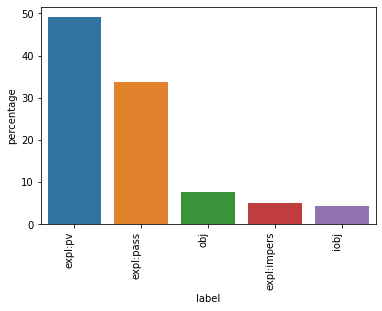

In [ ]:
get_class_dist(se_corpus.se_label)


In [ ]:
X = se_corpus.tokenized_text
y = se_corpus.se_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2022)


In [ ]:
label_encoder = preprocessing.LabelEncoder()
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

pool_vectorized = vectorizer.transform(pool.text).toarray()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [ ]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)


In [ ]:
class PoolDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)
    

In [ ]:
train_set = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_set = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

pool_set = PoolDataset(torch.from_numpy(pool_vectorized).float())


In [ ]:
train_features = torch.reshape(train_set.X_data,   (train_set.X_data.shape[0], 1,train_set.X_data.shape[1]))
train_labels = train_set.y_data


In [ ]:
test_features = torch.reshape(test_set.X_data,   (test_set.X_data.shape[0], 1,test_set.X_data.shape[1]))
test_labels = test_set.y_data


In [ ]:
X_pool = pool_set.X_data
X_pool = torch.reshape(X_pool,   (X_pool.shape[0], 1, X_pool.shape[1]))
X_pool = X_pool.detach().cpu().numpy()


## 4) Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim=32):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = 1
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(train_features.shape[2], hidden_dim, 1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 5)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [ ]:
# skorch library creates sklearn classifier from torch neural net

batch_size = 32
n_iters = 1000
epochs = int(n_iters/(len(train_set)/ batch_size))

# create the classifier
device = "cuda" if torch.cuda.is_available() else "cpu"
print('using: ', device)

# Callbacks: print accuracy when model is fitted
acc = EpochScoring(scoring='accuracy', on_train=True,
                         name='accuracy', lower_is_better=False)

f1 = EpochScoring(scoring='f1_weighted', on_train=True,
                         name='f1-score', lower_is_better=False)

callbacks = [acc, f1]

classifier = NeuralNetClassifier(module=LSTMModel,
                                 batch_size=batch_size,
                                 max_epochs= epochs,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam,
                                 lr=0.1,
                                 train_split=None,
                                 callbacks=callbacks,
                                 verbose=1,
                                 device=device)


using:  cuda


In [ ]:
classifier.fit(train_features, train_labels)


  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4932      0.4376        1.2042  0.3537
      2      0.8214      0.8088        0.5367  0.4214
      3      0.9191      0.9164        0.2302  0.4092
      4      0.9738      0.9734        0.0823  0.4189
      5      0.9932      0.9932        0.0247  0.4196
      6      0.9988      0.9988        0.0087  0.4179
      7      0.9988      0.9988        0.0058  0.4183
      8      1.0000      1.0000        0.0026  0.4176
      9      1.0000      1.0000        0.0019  0.4164


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(17200, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=5, bias=True)
  ),
)

***model is overfitting***: 
Run hyperparameter for best parameter setting

In [ ]:
# this hyperparameter search possibly has too many parameters: took 3+ hours to run
params = {
    'max_epochs': [10, 20],
    'batch_size':[16, 32, 64],
    'lr': [0.001, 0.01, 0.1],
    'module__hidden_dim': [64, 128, 256, 512],
}
gs = GridSearchCV(classifier, params, refit=False, cv=5, scoring='accuracy')

gs.fit(train_features, train_labels)


  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4882      0.3426        1.2769  0.7774
      2      0.6711      0.6016        0.9798  0.7406
      3      0.8506      0.8276        0.4766  0.7404
      4      0.9742      0.9736        0.1563  0.7362
      5      0.9941      0.9941        0.0603  0.7307
      6      0.9985      0.9985        0.0301  0.7313
      7      0.9996      0.9996        0.0176  0.7352
      8      0.9996      0.9996        0.0114  0.7341
      9      1.0000      1.0000        0.0079  0.7322
     10      1.0000      1.0000        0.0058  0.7239
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4768      0.3309        1.2821  0.7051
      2      0.6439      0.5730        0.9867  0.7241
      3      0.8411      0.8142        0.5081  0.7118
      4      0.9698      0.9691        0.1728  0.7113
      5      0.9948      0.9

      4      0.9930      0.9930        0.0636  0.9792
      5      0.9982      0.9982        0.0253  0.9864
      6      0.9996      0.9996        0.0135  1.0663
      7      1.0000      1.0000        0.0083  1.0645
      8      1.0000      1.0000        0.0055  1.0180
      9      1.0000      1.0000        0.0039  1.0099
     10      1.0000      1.0000        0.0029  1.0610
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4798      0.3956        1.2503  1.7993
      2      0.7583      0.7127        0.6972  1.7973
      3      0.9673      0.9666        0.1419  1.7882
      4      0.9967      0.9967        0.0329  1.8006
      5      0.9993      0.9993        0.0138  1.7497
      6      0.9996      0.9996        0.0074  1.7530
      7      1.0000      1.0000        0.0046  1.8006
      8      1.0000      1.0000        0.0031  1.7778
      9      1.0000      1.0000        0.0022  1.7482
     10      1.0000      1.0

      2      0.8146      0.7937        0.5388  3.2687
      3      0.9853      0.9852        0.0722  3.2691
      4      0.9982      0.9982        0.0151  3.2681
      5      0.9996      0.9996        0.0069  3.2699
      6      1.0000      1.0000        0.0038  3.2666
      7      1.0000      1.0000        0.0024  3.3185
      8      1.0000      1.0000        0.0016  3.2709
      9      1.0000      1.0000        0.0012  3.3143
     10      1.0000      1.0000        0.0009  3.2662
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4625      0.3441        1.2965  0.6471
      2      0.6637      0.5944        0.9833  0.7144
      3      0.8466      0.8188        0.4903  0.7198
      4      0.9735      0.9728        0.1597  0.7146
      5      0.9952      0.9952        0.0611  0.7130
      6      0.9985      0.9985        0.0307  0.7123
      7      0.9993      0.9993        0.0180  0.7240
      8      0.9996      0.9

     20      1.0000      1.0000        0.0008  0.7313
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4794      0.4082        1.2617  1.0805
      2      0.7104      0.6474        0.8446  1.0655
      3      0.9283      0.9234        0.2664  1.0708
      4      0.9912      0.9911        0.0670  1.0765
      5      0.9978      0.9978        0.0272  1.0780
      6      0.9993      0.9993        0.0142  1.0887
      7      0.9996      0.9996        0.0086  1.0781
      8      1.0000      1.0000        0.0057  1.0833
      9      1.0000      1.0000        0.0041  1.0788
     10      1.0000      1.0000        0.0030  1.0784
     11      1.0000      1.0000        0.0023  1.0785
     12      1.0000      1.0000        0.0018  1.0435
     13      1.0000      1.0000        0.0014  1.0517
     14      1.0000      1.0000        0.0012  1.0779
     15      1.0000      1.0000        0.0010  1.0779
     16      1.0000      1.0

      8      1.0000      1.0000        0.0031  1.7941
      9      1.0000      1.0000        0.0022  1.7897
     10      1.0000      1.0000        0.0016  1.7420
     11      1.0000      1.0000        0.0012  1.7256
     12      1.0000      1.0000        0.0010  1.7243
     13      1.0000      1.0000        0.0008  1.7257
     14      1.0000      1.0000        0.0006  1.7256
     15      1.0000      1.0000        0.0005  1.7252
     16      1.0000      1.0000        0.0004  1.7254
     17      1.0000      1.0000        0.0004  1.7246
     18      1.0000      1.0000        0.0003  1.7221
     19      1.0000      1.0000        0.0003  1.7250
     20      1.0000      1.0000        0.0002  1.7279
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4996      0.3882        1.2427  1.7837
      2      0.7575      0.7142        0.6950  1.7928
      3      0.9654      0.9648        0.1444  1.7720
      4      0.9963      0.9

  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4945      0.4157        1.2278  3.3456
      2      0.8068      0.7854        0.5476  3.3393
      3      0.9820      0.9819        0.0764  3.3018
      4      0.9985      0.9985        0.0168  3.3147
      5      0.9993      0.9993        0.0077  3.3391
      6      0.9996      0.9996        0.0044  3.2874
      7      1.0000      1.0000        0.0028  3.2691
      8      1.0000      1.0000        0.0019  3.3016
      9      1.0000      1.0000        0.0013  3.3095
     10      1.0000      1.0000        0.0010  3.2645
     11      1.0000      1.0000        0.0007  3.2838
     12      1.0000      1.0000        0.0006  3.2558
     13      1.0000      1.0000        0.0005  3.2989
     14      1.0000      1.0000        0.0004  3.2860
     15      1.0000      1.0000        0.0003  3.3088
     16      1.0000      1.0000        0.0003  3.2721
     17      1.0000      1.0

      9      1.0000      1.0000        0.0001  0.7130
     10      1.0000      1.0000        0.0001  0.7433
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5127      0.4507        1.1899  0.7266
      2      0.9298      0.9283        0.2173  0.7287
      3      0.9982      0.9982        0.0103  0.7283
      4      1.0000      1.0000        0.0005  0.7286
      5      1.0000      1.0000        0.0003  0.7093
      6      1.0000      1.0000        0.0002  0.6831
      7      1.0000      1.0000        0.0002  0.6594
      8      1.0000      1.0000        0.0001  0.6433
      9      1.0000      1.0000        0.0001  0.7366
     10      1.0000      1.0000        0.0001  0.7304
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5105      0.4414        1.1854  0.7272
      2      0.9253      0.9238        0.2191  0.7116
      3      0.9985      0.9

     10      1.0000      1.0000        0.0000  1.7280
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5075      0.4488        1.2067  1.7934
      2      0.9437      0.9429        0.1756  1.8026
      3      0.9930      0.9930        0.0228  1.7930
      4      0.9996      0.9996        0.0015  1.8024
      5      1.0000      1.0000        0.0001  1.7893
      6      1.0000      1.0000        0.0000  1.8010
      7      1.0000      1.0000        0.0000  1.8023
      8      1.0000      1.0000        0.0000  1.8003
      9      1.0000      1.0000        0.0000  1.7923
     10      1.0000      1.0000        0.0000  1.7848
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5061      0.4471        1.1939  1.7184
      2      0.9452      0.9448        0.1580  1.7108
      3      0.9879      0.9879        0.0377  1.7110
      4      0.9982      0.9

     12      1.0000      1.0000        0.0001  0.7130
     13      1.0000      1.0000        0.0001  0.7289
     14      1.0000      1.0000        0.0000  0.7281
     15      1.0000      1.0000        0.0000  0.7334
     16      1.0000      1.0000        0.0000  0.7309
     17      1.0000      1.0000        0.0000  0.7281
     18      1.0000      1.0000        0.0000  0.7303
     19      1.0000      1.0000        0.0000  0.7322
     20      1.0000      1.0000        0.0000  0.7210
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5037      0.4347        1.1926  0.7124
      2      0.9301      0.9287        0.2105  0.7340
      3      0.9989      0.9989        0.0077  0.7339
      4      1.0000      1.0000        0.0007  0.7311
      5      1.0000      1.0000        0.0003  0.7132
      6      1.0000      1.0000        0.0002  0.7118
      7      1.0000      1.0000        0.0002  0.7275
      8      1.0000      1.0

      5      1.0000      1.0000        0.0002  1.0781
      6      1.0000      1.0000        0.0001  1.0665
      7      1.0000      1.0000        0.0001  1.0023
      8      1.0000      1.0000        0.0001  0.9770
      9      1.0000      1.0000        0.0000  1.0210
     10      1.0000      1.0000        0.0000  1.0639
     11      1.0000      1.0000        0.0000  1.0646
     12      1.0000      1.0000        0.0000  1.0559
     13      1.0000      1.0000        0.0000  1.0823
     14      1.0000      1.0000        0.0000  1.0828
     15      1.0000      1.0000        0.0000  1.0819
     16      1.0000      1.0000        0.0000  1.0811
     17      1.0000      1.0000        0.0000  1.0349
     18      1.0000      1.0000        0.0000  0.9892
     19      1.0000      1.0000        0.0000  0.9865
     20      1.0000      1.0000        0.0000  0.9859
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5097      0.4

     20      1.0000      1.0000        0.0000  1.7935
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5097      0.4511        1.2050  1.7946
      2      0.9389      0.9380        0.1822  1.7415
      3      0.9941      0.9941        0.0227  1.7248
      4      1.0000      1.0000        0.0003  1.7364
      5      1.0000      1.0000        0.0001  1.7843
      6      1.0000      1.0000        0.0001  1.7793
      7      1.0000      1.0000        0.0000  1.7325
      8      1.0000      1.0000        0.0000  1.7852
      9      1.0000      1.0000        0.0000  1.7823
     10      1.0000      1.0000        0.0000  1.7298
     11      1.0000      1.0000        0.0000  1.7496
     12      1.0000      1.0000        0.0000  1.7914
     13      1.0000      1.0000        0.0000  1.7294
     14      1.0000      1.0000        0.0000  1.7259
     15      1.0000      1.0000        0.0000  1.7253
     16      1.0000      1.0

     12      1.0000      1.0000        0.0000  3.3314
     13      1.0000      1.0000        0.0000  3.2885
     14      1.0000      1.0000        0.0000  3.2722
     15      1.0000      1.0000        0.0000  3.2710
     16      1.0000      1.0000        0.0000  3.2710
     17      1.0000      1.0000        0.0000  3.2728
     18      1.0000      1.0000        0.0000  3.2722
     19      1.0000      1.0000        0.0000  3.3134
     20      1.0000      1.0000        0.0000  3.3313
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4987      0.4416        1.2017  3.2891
      2      0.9463      0.9460        0.1744  3.2550
      3      0.9886      0.9886        0.0321  3.2549
      4      0.9945      0.9945        0.0174  3.3233
      5      0.9993      0.9993        0.0023  3.2824
      6      1.0000      1.0000        0.0001  3.2686
      7      1.0000      1.0000        0.0000  3.2689
      8      1.0000      1.0

  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4838      0.4205        1.2570  1.0788
      2      0.7403      0.7321        0.8029  1.0686
      3      0.8985      0.8968        0.3223  1.0598
      4      0.9448      0.9446        0.1701  1.0695
      5      0.9897      0.9897        0.0355  1.0652
      6      0.9963      0.9963        0.0109  1.0640
      7      0.9989      0.9989        0.0033  1.0647
      8      1.0000      1.0000        0.0011  1.0318
      9      1.0000      1.0000        0.0008  1.0677
     10      1.0000      1.0000        0.0006  1.0638
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4656      0.4042        1.2796  1.0786
      2      0.7562      0.7487        0.7290  1.0786
      3      0.9117      0.9108        0.2678  1.0659
      4      0.9739      0.9739        0.0782  1.0787
      5      0.9956      0.9

      6      0.9993      0.9993        0.0029  3.2652
      7      1.0000      1.0000        0.0001  3.3031
      8      1.0000      1.0000        0.0000  3.2508
      9      1.0000      1.0000        0.0000  3.2619
     10      1.0000      1.0000        0.0000  3.2979
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4816      0.4292        1.4302  3.3072
      2      0.7870      0.7790        0.6805  3.2831
      3      0.9139      0.9133        0.2665  3.2983
      4      0.9547      0.9546        0.1447  3.2607
      5      0.9842      0.9842        0.0486  3.2635
      6      0.9945      0.9945        0.0130  3.2675
      7      0.9996      0.9996        0.0010  3.2627
      8      1.0000      1.0000        0.0002  3.2654
      9      1.0000      1.0000        0.0000  3.2701
     10      1.0000      1.0000        0.0000  3.3451
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  -------

      8      0.9989      0.9989        0.0059  0.7317
      9      0.9989      0.9989        0.0043  0.7316
     10      0.9996      0.9996        0.0035  0.7119
     11      0.9993      0.9993        0.0029  0.6799
     12      0.9993      0.9993        0.0025  0.6520
     13      1.0000      1.0000        0.0017  0.6370
     14      1.0000      1.0000        0.0013  0.6368
     15      1.0000      1.0000        0.0011  0.6960
     16      1.0000      1.0000        0.0010  0.7329
     17      1.0000      1.0000        0.0008  0.7365
     18      1.0000      1.0000        0.0008  0.7336
     19      1.0000      1.0000        0.0006  0.7331
     20      1.0000      1.0000        0.0005  0.7162
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4722      0.4105        1.2453  0.7100
      2      0.7367      0.7256        0.7994  0.7128
      3      0.8724      0.8710        0.3912  0.7137
      4      0.9603      0.9

     18      1.0000      1.0000        0.0002  0.9899
     19      1.0000      1.0000        0.0002  1.0188
     20      1.0000      1.0000        0.0002  1.0639
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4759      0.4212        1.2668  1.0812
      2      0.7532      0.7451        0.7545  1.0824
      3      0.8867      0.8855        0.3377  1.0759
      4      0.9353      0.9349        0.1941  1.0662
      5      0.9816      0.9815        0.0512  1.0600
      6      0.9971      0.9971        0.0115  1.0198
      7      0.9993      0.9993        0.0019  1.0675
      8      1.0000      1.0000        0.0008  1.0646
      9      1.0000      1.0000        0.0006  1.0462
     10      1.0000      1.0000        0.0005  1.0725
     11      1.0000      1.0000        0.0004  1.0649
     12      1.0000      1.0000        0.0004  1.0662
     13      1.0000      1.0000        0.0003  1.0720
     14      1.0000      1.0

      7      1.0000      1.0000        0.0008  1.7820
      8      1.0000      1.0000        0.0002  1.7228
      9      1.0000      1.0000        0.0001  1.7264
     10      1.0000      1.0000        0.0001  1.7306
     11      1.0000      1.0000        0.0001  1.8013
     12      1.0000      1.0000        0.0001  1.7473
     13      1.0000      1.0000        0.0001  1.7261
     14      1.0000      1.0000        0.0001  1.7237
     15      1.0000      1.0000        0.0001  1.7225
     16      1.0000      1.0000        0.0001  1.7222
     17      1.0000      1.0000        0.0001  1.7251
     18      1.0000      1.0000        0.0001  1.7816
     19      1.0000      1.0000        0.0001  1.7899
     20      1.0000      1.0000        0.0000  1.7997
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4753      0.4382        1.4777  3.3318
      2      0.8223      0.8190        0.6403  3.3142
      3      0.9352      0.9

     19      1.0000      1.0000        0.0000  7.9811
     20      1.0000      1.0000        0.0000  7.9644
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4198      0.3907        1.3569  1.3598
      2      0.5890      0.4989        1.0940  1.3724
      3      0.7605      0.6974        0.7638  1.3688
      4      0.8988      0.8869        0.3807  1.3786
      5      0.9779      0.9775        0.1683  1.3884
      6      0.9926      0.9926        0.0849  1.3667
      7      0.9974      0.9974        0.0496  1.3826
      8      0.9982      0.9982        0.0321  1.3675
      9      0.9993      0.9993        0.0222  1.3758
     10      0.9993      0.9993        0.0162  1.3474
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4415      0.3932        1.3480  1.3770
      2      0.5721      0.4742        1.0980  1.3815
      3      0.7568      0.6

      2      0.6513      0.5788        1.0029  1.7342
      3      0.8308      0.7967        0.5438  1.7372
      4      0.9621      0.9606        0.1956  1.7371
      5      0.9923      0.9922        0.0755  1.7267
      6      0.9978      0.9978        0.0380  1.7534
      7      0.9982      0.9982        0.0227  1.7687
      8      0.9996      0.9996        0.0150  1.7473
      9      0.9996      0.9996        0.0105  1.7206
     10      1.0000      1.0000        0.0078  1.7455
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4742      0.4148        1.2880  2.4822
      2      0.7241      0.6568        0.8740  2.4878
      3      0.9102      0.9019        0.3134  2.4786
      4      0.9838      0.9836        0.0830  2.4616
      5      0.9963      0.9963        0.0338  2.5007
      6      0.9989      0.9989        0.0178  2.4532
      7      0.9993      0.9993        0.0108  2.4921
      8      0.9996      0.9

      6      0.9996      0.9996        0.0095  4.0388
      7      0.9996      0.9996        0.0060  3.9955
      8      1.0000      1.0000        0.0041  4.0058
      9      1.0000      1.0000        0.0029  4.0159
     10      1.0000      1.0000        0.0022  4.0371
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4987      0.3780        1.2538  4.0005
      2      0.7565      0.7058        0.7195  4.0238
      3      0.9603      0.9589        0.1594  4.0522
      4      0.9956      0.9956        0.0362  4.0308
      5      0.9985      0.9985        0.0158  4.0606
      6      0.9996      0.9996        0.0088  4.0332
      7      1.0000      1.0000        0.0055  4.0394
      8      1.0000      1.0000        0.0038  4.0449
      9      1.0000      1.0000        0.0027  4.0320
     10      1.0000      1.0000        0.0020  4.0303
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  -------

      9      0.9993      0.9993        0.0209  1.3710
     10      0.9996      0.9996        0.0153  1.3576
     11      1.0000      1.0000        0.0116  1.3866
     12      1.0000      1.0000        0.0091  1.3611
     13      1.0000      1.0000        0.0073  1.3776
     14      1.0000      1.0000        0.0060  1.3550
     15      1.0000      1.0000        0.0050  1.3891
     16      1.0000      1.0000        0.0042  1.3951
     17      1.0000      1.0000        0.0036  1.3772
     18      1.0000      1.0000        0.0031  1.3698
     19      1.0000      1.0000        0.0027  1.3913
     20      1.0000      1.0000        0.0023  1.3684
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4680      0.3836        1.3071  1.7574
      2      0.6600      0.5889        1.0111  1.7469
      3      0.8429      0.8144        0.5260  1.7458
      4      0.9687      0.9679        0.1753  1.7404
      5      0.9930      0.9

     17      1.0000      1.0000        0.0017  1.7529
     18      1.0000      1.0000        0.0015  1.7364
     19      1.0000      1.0000        0.0013  1.7320
     20      1.0000      1.0000        0.0012  1.7289
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4673      0.4071        1.2871  2.4762
      2      0.7152      0.6484        0.8895  2.4452
      3      0.9099      0.9015        0.3200  2.4603
      4      0.9868      0.9866        0.0839  2.4605
      5      0.9967      0.9967        0.0343  2.4207
      6      0.9993      0.9993        0.0181  2.4186
      7      0.9996      0.9996        0.0111  2.4573
      8      0.9996      0.9996        0.0074  2.4564
      9      0.9996      0.9996        0.0053  2.4546
     10      1.0000      1.0000        0.0040  2.4588
     11      1.0000      1.0000        0.0031  2.4428
     12      1.0000      1.0000        0.0024  2.4590
     13      1.0000      1.0

      5      0.9985      0.9985        0.0173  4.1229
      6      0.9996      0.9996        0.0094  4.0979
      7      0.9996      0.9996        0.0058  4.0794
      8      1.0000      1.0000        0.0040  4.0721
      9      1.0000      1.0000        0.0029  4.0771
     10      1.0000      1.0000        0.0021  4.0834
     11      1.0000      1.0000        0.0017  4.0821
     12      1.0000      1.0000        0.0013  4.0646
     13      1.0000      1.0000        0.0011  4.0367
     14      1.0000      1.0000        0.0009  4.0524
     15      1.0000      1.0000        0.0007  4.0803
     16      1.0000      1.0000        0.0006  4.0652
     17      1.0000      1.0000        0.0006  4.0438
     18      1.0000      1.0000        0.0005  4.0366
     19      1.0000      1.0000        0.0004  4.0071
     20      1.0000      1.0000        0.0004  4.0235
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4963      0.3

      5      1.0000      1.0000        0.0007  1.3481
      6      1.0000      1.0000        0.0005  1.3734
      7      1.0000      1.0000        0.0004  1.3607
      8      1.0000      1.0000        0.0003  1.3745
      9      1.0000      1.0000        0.0002  1.3777
     10      1.0000      1.0000        0.0002  1.3710
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5055      0.4304        1.1993  1.3686
      2      0.8992      0.8919        0.2911  1.3508
      3      0.9989      0.9989        0.0124  1.3864
      4      1.0000      1.0000        0.0011  1.3631
      5      1.0000      1.0000        0.0007  1.3606
      6      1.0000      1.0000        0.0005  1.3723
      7      1.0000      1.0000        0.0004  1.3769
      8      1.0000      1.0000        0.0003  1.3558
      9      1.0000      1.0000        0.0002  1.3583
     10      1.0000      1.0000        0.0002  1.3765
  epoch    accuracy    f1-sc

      5      1.0000      1.0000        0.0001  2.4718
      6      1.0000      1.0000        0.0001  2.4902
      7      1.0000      1.0000        0.0001  2.4703
      8      1.0000      1.0000        0.0001  2.4668
      9      1.0000      1.0000        0.0001  2.4648
     10      1.0000      1.0000        0.0000  2.4675
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5171      0.4543        1.2001  2.4509
      2      0.9312      0.9298        0.1962  2.4368
      3      0.9904      0.9904        0.0247  2.4353
      4      0.9993      0.9993        0.0026  2.4463
      5      1.0000      1.0000        0.0002  2.4676
      6      1.0000      1.0000        0.0001  2.4633
      7      1.0000      1.0000        0.0001  2.4672
      8      1.0000      1.0000        0.0001  2.4845
      9      1.0000      1.0000        0.0001  2.4780
     10      1.0000      1.0000        0.0001  2.4780
  epoch    accuracy    f1-sc

      7      1.0000      1.0000        0.0003  1.3739
      8      1.0000      1.0000        0.0003  1.3890
      9      1.0000      1.0000        0.0002  1.3624
     10      1.0000      1.0000        0.0002  1.3621
     11      1.0000      1.0000        0.0001  1.3567
     12      1.0000      1.0000        0.0001  1.3885
     13      1.0000      1.0000        0.0001  1.3643
     14      1.0000      1.0000        0.0001  1.3463
     15      1.0000      1.0000        0.0001  1.3804
     16      1.0000      1.0000        0.0001  1.3873
     17      1.0000      1.0000        0.0001  1.3376
     18      1.0000      1.0000        0.0001  1.3636
     19      1.0000      1.0000        0.0001  1.3442
     20      1.0000      1.0000        0.0000  1.3661
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4978      0.4376        1.2026  1.3994
      2      0.9021      0.8959        0.2901  1.3628
      3      0.9989      0.9

      2      0.9341      0.9323        0.2073  1.7365
      3      0.9982      0.9982        0.0092  1.7231
      4      1.0000      1.0000        0.0005  1.7075
      5      1.0000      1.0000        0.0003  1.7332
      6      1.0000      1.0000        0.0002  1.7193
      7      1.0000      1.0000        0.0002  1.7499
      8      1.0000      1.0000        0.0001  1.7269
      9      1.0000      1.0000        0.0001  1.6881
     10      1.0000      1.0000        0.0001  1.7255
     11      1.0000      1.0000        0.0001  1.7314
     12      1.0000      1.0000        0.0001  1.7540
     13      1.0000      1.0000        0.0001  1.7336
     14      1.0000      1.0000        0.0000  1.7232
     15      1.0000      1.0000        0.0000  1.7200
     16      1.0000      1.0000        0.0000  1.7453
     17      1.0000      1.0000        0.0000  1.7407
     18      1.0000      1.0000        0.0000  1.7465
     19      1.0000      1.0000        0.0000  1.7181
     20      1.0000      1.0

     17      1.0000      1.0000        0.0000  2.4901
     18      1.0000      1.0000        0.0000  2.4634
     19      1.0000      1.0000        0.0000  2.4774
     20      1.0000      1.0000        0.0000  2.4637
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5149      0.4561        1.2017  2.4581
      2      0.9389      0.9380        0.1883  2.4722
      3      0.9893      0.9893        0.0284  2.4627
      4      0.9989      0.9989        0.0041  2.4943
      5      1.0000      1.0000        0.0005  2.4900
      6      1.0000      1.0000        0.0002  2.4691
      7      1.0000      1.0000        0.0001  2.4480
      8      1.0000      1.0000        0.0001  2.4787
      9      1.0000      1.0000        0.0001  2.4823
     10      1.0000      1.0000        0.0001  2.5029
     11      1.0000      1.0000        0.0000  2.4772
     12      1.0000      1.0000        0.0000  2.4815
     13      1.0000      1.0

      8      1.0000      1.0000        0.0002  4.0296
      9      1.0000      1.0000        0.0000  4.0336
     10      1.0000      1.0000        0.0000  4.0164
     11      1.0000      1.0000        0.0000  4.0390
     12      1.0000      1.0000        0.0000  4.0515
     13      1.0000      1.0000        0.0000  4.0449
     14      1.0000      1.0000        0.0000  4.0470
     15      1.0000      1.0000        0.0000  4.0593
     16      1.0000      1.0000        0.0000  4.0409
     17      1.0000      1.0000        0.0000  4.0247
     18      1.0000      1.0000        0.0000  4.0557
     19      1.0000      1.0000        0.0000  4.0185
     20      1.0000      1.0000        0.0000  4.0227
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5230      0.4609        1.1993  4.0809
      2      0.9470      0.9466        0.1590  4.0431
      3      0.9901      0.9901        0.0282  4.0732
      4      0.9956      0.9

      9      1.0000      1.0000        0.0002  1.7250
     10      1.0000      1.0000        0.0002  1.7333
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4720      0.3979        1.2711  1.7354
      2      0.7756      0.7687        0.6167  1.7302
      3      0.9444      0.9441        0.1651  1.7322
      4      0.9831      0.9831        0.0510  1.7554
      5      0.9978      0.9978        0.0082  1.7394
      6      1.0000      1.0000        0.0014  1.7388
      7      1.0000      1.0000        0.0005  1.7573
      8      1.0000      1.0000        0.0003  1.7390
      9      1.0000      1.0000        0.0002  1.7332
     10      1.0000      1.0000        0.0002  1.7411
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4895      0.4355        1.2515  1.7418
      2      0.7882      0.7760        0.6060  1.7269
      3      0.9312      0.9

      6      1.0000      1.0000        0.0002  4.0247
      7      1.0000      1.0000        0.0001  4.0548
      8      1.0000      1.0000        0.0001  4.0766
      9      1.0000      1.0000        0.0001  4.0733
     10      1.0000      1.0000        0.0001  4.0560
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4650      0.3918        1.4908  4.0654
      2      0.7888      0.7803        0.6714  4.0513
      3      0.9500      0.9497        0.1536  4.0269
      4      0.9937      0.9937        0.0209  4.0226
      5      0.9996      0.9996        0.0023  4.0188
      6      1.0000      1.0000        0.0003  4.0320
      7      1.0000      1.0000        0.0002  4.0508
      8      1.0000      1.0000        0.0001  4.0594
      9      1.0000      1.0000        0.0001  4.1016
     10      1.0000      1.0000        0.0001  4.0816
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  -------

     11      1.0000      1.0000        0.0009  1.4036
     12      1.0000      1.0000        0.0007  1.3810
     13      1.0000      1.0000        0.0006  1.3474
     14      1.0000      1.0000        0.0005  1.3623
     15      1.0000      1.0000        0.0004  1.3807
     16      1.0000      1.0000        0.0004  1.3661
     17      1.0000      1.0000        0.0004  1.3591
     18      1.0000      1.0000        0.0003  1.3774
     19      1.0000      1.0000        0.0003  1.3612
     20      1.0000      1.0000        0.0003  1.3877
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4803      0.4135        1.2259  1.3583
      2      0.8084      0.8009        0.5618  1.3759
      3      0.9338      0.9333        0.1982  1.3361
      4      0.9757      0.9757        0.0732  1.3688
      5      0.9945      0.9945        0.0177  1.3476
      6      0.9996      0.9996        0.0031  1.3636
      7      0.9996      0.9

      2      0.7716      0.7649        0.6597  1.7227
      3      0.9246      0.9242        0.2286  1.7134
      4      0.9691      0.9691        0.0823  1.7223
      5      0.9934      0.9934        0.0144  1.7199
      6      1.0000      1.0000        0.0011  1.7275
      7      1.0000      1.0000        0.0004  1.7152
      8      1.0000      1.0000        0.0003  1.7188
      9      1.0000      1.0000        0.0003  1.7250
     10      1.0000      1.0000        0.0002  1.7468
     11      1.0000      1.0000        0.0002  1.7137
     12      1.0000      1.0000        0.0002  1.7282
     13      1.0000      1.0000        0.0002  1.7402
     14      1.0000      1.0000        0.0001  1.7392
     15      1.0000      1.0000        0.0001  1.7706
     16      1.0000      1.0000        0.0001  1.7338
     17      1.0000      1.0000        0.0001  1.7382
     18      1.0000      1.0000        0.0001  1.7599
     19      1.0000      1.0000        0.0001  1.7352
     20      1.0000      1.0

     14      1.0000      1.0000        0.0001  2.4918
     15      1.0000      1.0000        0.0001  2.4509
     16      1.0000      1.0000        0.0001  2.4542
     17      1.0000      1.0000        0.0001  2.4914
     18      1.0000      1.0000        0.0001  2.4780
     19      1.0000      1.0000        0.0001  2.4697
     20      1.0000      1.0000        0.0000  2.4756
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4831      0.4248        1.4820  4.0469
      2      0.7792      0.7693        0.6988  4.0346
      3      0.9433      0.9429        0.1706  4.0469
      4      0.9845      0.9845        0.0423  4.0400
      5      0.9989      0.9989        0.0057  4.0569
      6      1.0000      1.0000        0.0005  4.0594
      7      1.0000      1.0000        0.0003  4.0640
      8      1.0000      1.0000        0.0002  4.0551
      9      1.0000      1.0000        0.0002  4.0678
     10      1.0000      1.0

      5      0.8874      0.8690        0.4434  0.7097
      6      0.9595      0.9581        0.2451  0.7139
      7      0.9834      0.9832        0.1414  0.7053
      8      0.9908      0.9908        0.0895  0.7140
      9      0.9956      0.9956        0.0611  0.7215
     10      0.9974      0.9974        0.0439  0.7131
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4805      0.3377        1.3959  0.7177
      2      0.5265      0.3952        1.1438  0.7183
      3      0.7068      0.6385        0.9696  0.7101
      4      0.7958      0.7282        0.6940  0.7192
      5      0.8911      0.8756        0.4179  0.7069
      6      0.9617      0.9604        0.2368  0.7039
      7      0.9860      0.9858        0.1405  0.7176
      8      0.9912      0.9911        0.0900  0.7045
      9      0.9948      0.9948        0.0619  0.7189
     10      0.9978      0.9978        0.0449  0.7220
  epoch    accuracy    f1-sc

      5      0.9720      0.9713        0.1968  0.9210
      6      0.9923      0.9922        0.0981  0.9102
      7      0.9945      0.9944        0.0577  0.9503
      8      0.9978      0.9978        0.0378  0.9215
      9      0.9982      0.9982        0.0264  0.9088
     10      0.9989      0.9989        0.0194  0.9225
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4753      0.3869        1.3314  1.3128
      2      0.6667      0.5965        1.0385  1.2943
      3      0.8010      0.7481        0.6227  1.2971
      4      0.9459      0.9431        0.2370  1.2991
      5      0.9845      0.9843        0.0932  1.2957
      6      0.9952      0.9952        0.0483  1.3262
      7      0.9978      0.9978        0.0294  1.3277
      8      0.9993      0.9993        0.0194  1.3334
      9      0.9993      0.9993        0.0135  1.2982
     10      0.9996      0.9996        0.0100  1.3056
  epoch    accuracy    f1-sc

      7      0.9993      0.9993        0.0152  1.9542
      8      0.9996      0.9996        0.0100  1.9552
      9      0.9996      0.9996        0.0072  1.9601
     10      1.0000      1.0000        0.0054  1.9559
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4693      0.3590        1.3034  1.9533
      2      0.7083      0.6398        0.9213  1.9667
      3      0.8834      0.8673        0.3975  1.9730
      4      0.9849      0.9847        0.1109  1.9765
      5      0.9945      0.9944        0.0436  1.9683
      6      0.9982      0.9982        0.0236  1.9794
      7      0.9989      0.9989        0.0143  1.9788
      8      0.9996      0.9996        0.0095  1.9839
      9      1.0000      1.0000        0.0068  2.0045
     10      1.0000      1.0000        0.0051  2.0225
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4025      0.3

      7      0.9849      0.9847        0.1533  0.7235
      8      0.9937      0.9937        0.0968  0.7141
      9      0.9963      0.9963        0.0656  0.7276
     10      0.9978      0.9978        0.0471  0.7246
     11      0.9982      0.9982        0.0353  0.7184
     12      0.9985      0.9985        0.0274  0.7180
     13      0.9996      0.9996        0.0219  0.7353
     14      0.9996      0.9996        0.0178  0.7195
     15      0.9996      0.9996        0.0148  0.7199
     16      1.0000      1.0000        0.0124  0.7257
     17      1.0000      1.0000        0.0106  0.7179
     18      1.0000      1.0000        0.0091  0.7097
     19      1.0000      1.0000        0.0080  0.7098
     20      1.0000      1.0000        0.0070  0.7227
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4882      0.3234        1.3737  0.9291
      2      0.5806      0.4856        1.1051  0.9264
      3      0.7564      0.6

     11      0.9989      0.9989        0.0149  0.9313
     12      0.9996      0.9996        0.0117  0.9281
     13      1.0000      1.0000        0.0095  0.9178
     14      1.0000      1.0000        0.0078  0.9079
     15      1.0000      1.0000        0.0065  0.9158
     16      1.0000      1.0000        0.0055  0.9273
     17      1.0000      1.0000        0.0047  0.9167
     18      1.0000      1.0000        0.0041  0.9156
     19      1.0000      1.0000        0.0036  0.9179
     20      1.0000      1.0000        0.0031  0.9218
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4687      0.4140        1.3186  1.3143
      2      0.6762      0.6071        1.0333  1.3117
      3      0.8039      0.7539        0.6202  1.3064
      4      0.9470      0.9443        0.2367  1.3151
      5      0.9857      0.9855        0.0933  1.3170
      6      0.9960      0.9959        0.0485  1.3084
      7      0.9982      0.9

     18      1.0000      1.0000        0.0021  1.2900
     19      1.0000      1.0000        0.0019  1.2977
     20      1.0000      1.0000        0.0017  1.2922
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4665      0.4134        1.3098  2.0286
      2      0.7211      0.6532        0.9334  1.9969
      3      0.8863      0.8711        0.4015  1.9762
      4      0.9801      0.9798        0.1119  1.9628
      5      0.9952      0.9952        0.0452  1.9633
      6      0.9982      0.9982        0.0244  1.9624
      7      0.9993      0.9993        0.0149  1.9637
      8      0.9993      0.9993        0.0098  1.9592
      9      0.9996      0.9996        0.0070  1.9638
     10      1.0000      1.0000        0.0052  1.9585
     11      1.0000      1.0000        0.0040  1.9538
     12      1.0000      1.0000        0.0032  1.9598
     13      1.0000      1.0000        0.0026  1.9524
     14      1.0000      1.0

      5      1.0000      1.0000        0.0013  0.7289
      6      1.0000      1.0000        0.0008  0.7225
      7      1.0000      1.0000        0.0006  0.7259
      8      1.0000      1.0000        0.0005  0.7168
      9      1.0000      1.0000        0.0004  0.7389
     10      1.0000      1.0000        0.0003  0.7209
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4908      0.4140        1.2216  0.7426
      2      0.8698      0.8569        0.3806  0.7184
      3      0.9985      0.9985        0.0184  0.7262
      4      1.0000      1.0000        0.0029  0.7049
      5      1.0000      1.0000        0.0015  0.7194
      6      1.0000      1.0000        0.0010  0.7158
      7      1.0000      1.0000        0.0007  0.7211
      8      1.0000      1.0000        0.0006  0.7704
      9      1.0000      1.0000        0.0004  0.7270
     10      1.0000      1.0000        0.0004  0.7220
  epoch    accuracy    f1-sc

      6      1.0000      1.0000        0.0002  1.2903
      7      1.0000      1.0000        0.0002  1.2953
      8      1.0000      1.0000        0.0001  1.3074
      9      1.0000      1.0000        0.0001  1.3158
     10      1.0000      1.0000        0.0001  1.3213
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5052      0.4443        1.2136  1.3038
      2      0.9194      0.9159        0.2289  1.2998
      3      0.9960      0.9960        0.0167  1.2982
      4      0.9945      0.9945        0.0181  1.3939
      5      0.9952      0.9952        0.0158  1.3283
      6      0.9978      0.9978        0.0046  1.3120
      7      1.0000      1.0000        0.0006  1.3073
      8      1.0000      1.0000        0.0002  1.2966
      9      1.0000      1.0000        0.0002  1.3079
     10      1.0000      1.0000        0.0001  1.2980
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  -------

      6      1.0000      1.0000        0.0010  0.7918
      7      1.0000      1.0000        0.0008  0.7946
      8      1.0000      1.0000        0.0006  0.7351
      9      1.0000      1.0000        0.0005  0.7246
     10      1.0000      1.0000        0.0004  0.7415
     11      1.0000      1.0000        0.0003  0.7171
     12      1.0000      1.0000        0.0003  0.7414
     13      1.0000      1.0000        0.0002  0.7315
     14      1.0000      1.0000        0.0002  0.7354
     15      1.0000      1.0000        0.0002  0.7166
     16      1.0000      1.0000        0.0002  0.7356
     17      1.0000      1.0000        0.0001  0.7209
     18      1.0000      1.0000        0.0001  0.7185
     19      1.0000      1.0000        0.0001  0.7061
     20      1.0000      1.0000        0.0001  0.7396
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4875      0.4186        1.2274  0.7212
      2      0.8771      0.8

      2      0.9021      0.8952        0.2859  0.9888
      3      0.9978      0.9978        0.0113  0.9625
      4      1.0000      1.0000        0.0019  1.0270
      5      1.0000      1.0000        0.0007  1.0115
      6      1.0000      1.0000        0.0005  0.9961
      7      1.0000      1.0000        0.0003  0.9435
      8      1.0000      1.0000        0.0003  0.9300
      9      1.0000      1.0000        0.0002  0.9326
     10      1.0000      1.0000        0.0002  0.9375
     11      1.0000      1.0000        0.0001  0.9066
     12      1.0000      1.0000        0.0001  0.9228
     13      1.0000      1.0000        0.0001  1.0198
     14      1.0000      1.0000        0.0001  0.9761
     15      1.0000      1.0000        0.0001  0.9314
     16      1.0000      1.0000        0.0001  0.9326
     17      1.0000      1.0000        0.0001  0.9357
     18      1.0000      1.0000        0.0001  0.9331
     19      1.0000      1.0000        0.0001  0.9181
     20      1.0000      1.0

     17      1.0000      1.0000        0.0000  1.3054
     18      1.0000      1.0000        0.0000  1.3086
     19      1.0000      1.0000        0.0000  1.3039
     20      1.0000      1.0000        0.0000  1.3014
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5044      0.4423        1.2162  1.3049
      2      0.9220      0.9181        0.2253  1.3006
      3      0.9963      0.9963        0.0151  1.2889
      4      0.9993      0.9993        0.0025  1.3013
      5      1.0000      1.0000        0.0004  1.2923
      6      1.0000      1.0000        0.0002  1.3094
      7      1.0000      1.0000        0.0001  1.3049
      8      1.0000      1.0000        0.0001  1.2843
      9      1.0000      1.0000        0.0001  1.3018
     10      1.0000      1.0000        0.0001  1.3073
     11      1.0000      1.0000        0.0001  1.3028
     12      1.0000      1.0000        0.0001  1.2815
     13      1.0000      1.0

      9      1.0000      1.0000        0.0001  1.9638
     10      1.0000      1.0000        0.0000  1.9686
     11      1.0000      1.0000        0.0000  1.9649
     12      1.0000      1.0000        0.0000  1.9616
     13      1.0000      1.0000        0.0000  1.9623
     14      1.0000      1.0000        0.0000  2.0297
     15      1.0000      1.0000        0.0000  1.9598
     16      1.0000      1.0000        0.0000  1.9772
     17      1.0000      1.0000        0.0000  1.9991
     18      1.0000      1.0000        0.0000  2.0043
     19      1.0000      1.0000        0.0000  2.0167
     20      1.0000      1.0000        0.0000  1.9553
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5116      0.4531        1.2156  2.0072
      2      0.9172      0.9157        0.2506  1.9543
      3      0.9864      0.9864        0.0396  1.9555
      4      0.9971      0.9971        0.0066  1.9570
      5      1.0000      1.0

      4      0.9956      0.9956        0.0163  0.9263
      5      1.0000      1.0000        0.0017  0.9254
      6      1.0000      1.0000        0.0006  0.9094
      7      1.0000      1.0000        0.0004  0.9171
      8      1.0000      1.0000        0.0003  0.9227
      9      1.0000      1.0000        0.0002  0.9248
     10      1.0000      1.0000        0.0002  0.9107
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4937      0.4381        1.2621  0.9292
      2      0.8466      0.8391        0.4371  0.9334
      3      0.9860      0.9860        0.0484  0.9316
      4      0.9993      0.9993        0.0042  0.9312
      5      1.0000      1.0000        0.0004  0.9192
      6      1.0000      1.0000        0.0002  0.9736
      7      1.0000      1.0000        0.0002  1.0256
      8      1.0000      1.0000        0.0002  0.9534
      9      1.0000      1.0000        0.0001  0.9290
     10      1.0000      1.0

      3      0.9702      0.9698        0.0853  1.9645
      4      0.9960      0.9959        0.0121  1.9549
      5      1.0000      1.0000        0.0021  1.9717
      6      1.0000      1.0000        0.0009  1.9580
      7      1.0000      1.0000        0.0004  1.9720
      8      1.0000      1.0000        0.0003  1.9754
      9      1.0000      1.0000        0.0002  1.9456
     10      1.0000      1.0000        0.0002  1.9583
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4415      0.3935        1.7901  1.9731
      2      0.7774      0.7624        0.6406  1.9659
      3      0.9750      0.9749        0.0822  1.9646
      4      0.9982      0.9982        0.0119  1.9997
      5      0.9985      0.9985        0.0043  1.9787
      6      0.9996      0.9996        0.0010  1.9559
      7      1.0000      1.0000        0.0003  1.9716
      8      1.0000      1.0000        0.0002  1.9578
      9      1.0000      1.0

     20      1.0000      1.0000        0.0001  0.7620
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4873      0.4344        1.2336  0.7255
      2      0.8396      0.8270        0.4732  0.7263
      3      0.9757      0.9755        0.0806  0.7263
      4      0.9974      0.9974        0.0121  0.7128
      5      1.0000      1.0000        0.0023  0.7126
      6      1.0000      1.0000        0.0009  0.7233
      7      1.0000      1.0000        0.0006  0.7147
      8      1.0000      1.0000        0.0005  0.7221
      9      1.0000      1.0000        0.0004  0.7214
     10      1.0000      1.0000        0.0003  0.7449
     11      1.0000      1.0000        0.0003  0.7106
     12      1.0000      1.0000        0.0003  0.7167
     13      1.0000      1.0000        0.0002  0.7120
     14      1.0000      1.0000        0.0002  0.7025
     15      1.0000      1.0000        0.0002  0.7255
     16      1.0000      1.0

     11      1.0000      1.0000        0.0001  0.9359
     12      1.0000      1.0000        0.0001  1.0165
     13      1.0000      1.0000        0.0001  0.9227
     14      1.0000      1.0000        0.0001  0.9222
     15      1.0000      1.0000        0.0001  0.9066
     16      1.0000      1.0000        0.0001  0.9057
     17      1.0000      1.0000        0.0001  0.9077
     18      1.0000      1.0000        0.0001  0.9057
     19      1.0000      1.0000        0.0001  0.9075
     20      1.0000      1.0000        0.0001  0.9172
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4777      0.4202        1.2743  0.9122
      2      0.8135      0.8016        0.5075  0.9105
      3      0.9720      0.9720        0.0812  0.9120
      4      0.9967      0.9967        0.0123  0.9189
      5      0.9993      0.9993        0.0021  0.9742
      6      1.0000      1.0000        0.0008  0.9994
      7      1.0000      1.0

      3      0.9783      0.9783        0.0755  1.3214
      4      0.9982      0.9982        0.0145  1.3162
      5      0.9985      0.9985        0.0215  1.3097
      6      0.9996      0.9996        0.0007  1.2875
      7      1.0000      1.0000        0.0004  1.3145
      8      1.0000      1.0000        0.0002  1.3138
      9      1.0000      1.0000        0.0002  1.3134
     10      1.0000      1.0000        0.0001  1.3035
     11      1.0000      1.0000        0.0001  1.3019
     12      1.0000      1.0000        0.0001  1.3150
     13      1.0000      1.0000        0.0001  1.3042
     14      1.0000      1.0000        0.0001  1.2994
     15      1.0000      1.0000        0.0001  1.3121
     16      1.0000      1.0000        0.0001  1.2984
     17      1.0000      1.0000        0.0001  1.3063
     18      1.0000      1.0000        0.0001  1.3005
     19      1.0000      1.0000        0.0001  1.3057
     20      1.0000      1.0000        0.0001  1.2888
  epoch    accuracy    f1-sc

     16      1.0000      1.0000        0.0001  1.9524
     17      1.0000      1.0000        0.0001  1.9641
     18      1.0000      1.0000        0.0001  1.9645
     19      1.0000      1.0000        0.0001  1.9493
     20      1.0000      1.0000        0.0001  1.9626


GridSearchCV(cv=5,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(17200, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=5, bias=True)
  ),
),
             param_grid={'batch_size': [16, 32, 64], 'lr': [0.001, 0.01, 0.1],
                         'max_epochs': [10, 20],
                         'module__hidden_dim': [64, 128, 256, 512]},
             refit=False, scoring='accuracy')

In [ ]:
print('\ngs.best_score_ ', gs.best_score_, '\ngs.best_params_', gs.best_params_)



gs.best_score_  0.5514991769903836 
gs.best_params_ {'batch_size': 64, 'lr': 0.001, 'max_epochs': 10, 'module__hidden_dim': 64}


In [ ]:
# refit with optimal parameters

classifier = NeuralNetClassifier(module=LSTMModel,
                                 module__hidden_dim = 64,
                                 batch_size=64,
                                 max_epochs= 10,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam,
                                 lr=0.001,
                                 train_split=None,
                                 callbacks=callbacks,
                                 verbose=1,
                                 device=device)

classifier.fit(train_features, train_labels)


  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.3832      0.3758        1.4401  0.4183
      2      0.5406      0.4241        1.1485  0.3004
      3      0.7219      0.6530        0.9368  0.3103
      4      0.8125      0.7646        0.6109  0.2953
      5      0.9244      0.9183        0.3322  0.3028
      6      0.9762      0.9756        0.1775  0.3027
      7      0.9906      0.9905        0.1034  0.3094
      8      0.9956      0.9956        0.0664  0.3004
      9      0.9976      0.9976        0.0459  0.3056
     10      0.9985      0.9985        0.0335  0.3005


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(17200, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=5, bias=True)
  ),
)

In [ ]:
targets = label_encoder.classes_

y_pred_test = classifier.predict(test_features)
print(classification_report(test_labels, y_pred_test, target_names=targets, zero_division=0))


              precision    recall  f1-score   support

 expl:impers       0.70      0.16      0.26        44
   expl:pass       0.52      0.49      0.51       287
     expl:pv       0.60      0.77      0.67       417
        iobj       0.00      0.00      0.00        37
         obj       0.27      0.09      0.14        65

    accuracy                           0.56       850
   macro avg       0.42      0.30      0.32       850
weighted avg       0.53      0.56      0.53       850



***model performance mismatch problem***: the model is overfitting on the train data and thus performs much worse on the test data 
(https://machinelearningmastery.com/the-model-performance-mismatch-problem/)

## 3) Active Learner

In [ ]:
train_features = train_features.detach().cpu().numpy()
train_labels = train_labels.detach().cpu().numpy()

In [ ]:
# no training arguments because classifier is already fitted
learner = ActiveLearner(estimator=classifier,
                        query_strategy=uncertainty_sampling,
                        X_training=train_features,
                        y_training=train_labels,
)


In [ ]:
n_instances = 3 # while testing script
# n_instances = 20 
accuracies = [learner.score(test_features, test_labels)] # append first accuracy without learning
pool_sent_list= list() # store annotated sentences and the labels
pool_label_list= list()


### Loop
- stops after 20 iterations
- prompt sentence

Problem: if annotation is 'None' (e.g in the case a sentence is discarded) the loop breaks. We have to discard certain sentences because when creating the underlying corpus
phrases that do not contain 'se' like 'aunque a tu mac no le pase nada' were not discarded because there is no suited programmatical way to differentiate btw. 'pase' and 'siéntese'.

In [ ]:
number_of_loops = 3


In [ ]:
for i in range(number_of_loops):# annotate 10 times 20 instances

    # query new instances
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    predicted_proba = get_learners_preds(learner.predict_proba(X_pool[query_idx]))
    sentences = pool.text.iloc[query_idx]

    # annotate the queried instances
    annotation = list()
    counter = 0
    for sent, proba in zip(sentences, predicted_proba):
        counter += 1
        sorted_proba = sorted(proba.items(), key=lambda kv: kv[1], reverse=True)
        prompt = '\n'+'loop: '+str(i+1)+'\n'+'sentence: '+str(counter)+'\n'+'The learners predictions are:'+'\n'+str(sorted_proba)+'\n\n'+sent+'\n'
        label = str(input(prompt))
        annotation.append(label)

    # keep track of annotations
    sent_list = sentences.to_list()
    pool_sent_list.append(sent_list)
    pool_label_list.append(annotation)

    # filter out sentences that were assigned 'None'; the learner should not see them
    if 'None' in annotation:
        print('Note: you either discarded samples or did not annotate all samples')
        discarded_idxs=[idx for idx, sample in enumerate(annotation) if sample == 'None'] # TODO
        discarded_idxs = sorted(discarded_idxs, reverse=True)
        for index in discarded_idxs:
            query_inst = np.delete(query_inst, index, axis=0)
        annotation = list(filter('None'.__ne__, annotation))


    # teach the learner
    y_pool = label_encoder.transform(annotation)
    learner.teach(query_inst, y_pool)
    accuracies.append(learner.score(X=test_features, y=test_labels))

    # delete queried instances from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    


loop: 1
sentence: 1
The learners predictions are:
[('iobj', 0.22), ('expl:pass', 0.21), ('expl:pv', 0.2), ('obj', 0.19), ('expl:immpers', 0.18)]

Las técnicas que haya sido testigo de la base de la tecnología futura AO que Maurice contribuyo a sistematizar .
None

loop: 1
sentence: 2
The learners predictions are:
[('expl:pass', 0.22), ('iobj', 0.22), ('expl:immpers', 0.2), ('obj', 0.2), ('expl:pv', 0.16)]

No es posible un desarrollo campesino si el Gobierno no se lo toma en serio .
obj

loop: 1
sentence: 3
The learners predictions are:
[('expl:pass', 0.22), ('expl:pv', 0.22), ('obj', 0.21), ('iobj', 0.19), ('expl:immpers', 0.16)]

Y como siempre , en una crianza guíada más por la intuición que el miedo infundido por el sistema , sintiendo nos libres de elegir , incluso si la enfermera nos dice que se le va a deformar el craneo a nuestro hijo .
expl:pv
Note: you either discarded samples or did not annotate all samples
Re-initializing module because the following parameters were re-set

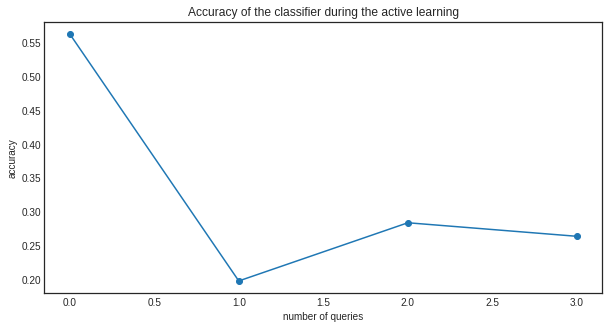

In [ ]:
with plt.style.context('bmh'):
    csfont = {'fontname':'Times New Roman'}
    plt.figure(figsize=(12, 8))
    plt.plot(range(number_of_loops+1), accuracies)
    plt.scatter(range(number_of_loops+1), accuracies)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20, **csfont)
    plt.xticks(np.arange(0, 11, 1), fontsize=20, **csfont)
    plt.xlabel('loop number',fontsize=24, **csfont)
    plt.ylabel('accuracy',fontsize=24, **csfont)
    plt.savefig('al_plots/es_pytorch.png')
    plt.tight_layout()
    plt.show()
    

In [ ]:
max(accuracies)


0.5623529411764706

In [ ]:
# create df from annotations
sent_flattened = get_flattened_list(pool_sent_list)
label_flattened = get_flattened_list(pool_label_list)

labeled_pool = pd.DataFrame(list(zip(sent_flattened, label_flattened)),
               columns =['text', 'se_label'])
print(labeled_pool.shape)
print(labeled_pool.head())


(9, 2)
                                                text se_label
0  Las técnicas que haya sido testigo de la base ...     None
1  No es posible un desarrollo campesino si el Go...      obj
2  Y como siempre , en una crianza guíada más por...  expl:pv
3              Cuando la hemorragia se limita a un ?     None
4  Tampoco tengo la sensación de que los blogs de...     iobj


In [ ]:
# save labeled pool
labeled_pool.to_csv('labeled_data/es_pytorch_annotations.txt', header=None, index=False,  sep='\t')
